# Setup

## Bibliothèques Python

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from osgeo import gdal
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import (GridSearchCV,
                                    StratifiedGroupKFold,
                                    train_test_split)
from sklearn.metrics import (accuracy_score,
                            classification_report,
                            confusion_matrix)

# libsigma
sys.path.append(os.path.abspath(".."))
from libsigma.read_and_write import (get_origin_coordinates,
                                    load_img_as_array,
                                    write_image,
                                    get_image_dimension,
                                    get_pixel_size,
                                    open_image)
from libsigma.classification import get_samples_from_roi
from libsigma.plots import plot_cm

# my_function.py
from my_function import rasterise_gdal, calcul_nari, plot_contrib

## Chemins

In [ ]:
results_dir = os.path.join("..", "results")
figures_dir = os.path.join(results_dir, "figure")
data_dir = os.path.join("..", "data", "projet_eval")
img_dir = os.path.join(".", "img")

os.makedirs(results_dir,exist_ok=True)
os.makedirs(figures_dir,exist_ok=True)
os.makedirs(img_dir,exist_ok=True)

# 4.2. Analyse des échantillons


## 4.2.1. Nombre d’échantillons

### Nombre de polygones par classe

#### Diagramme en bâtons

Fichier créé : /home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png


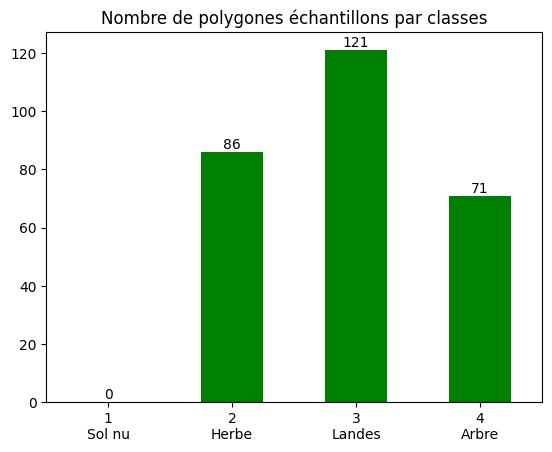

In [ ]:
shp_path = os.path.join(
    data_dir,
    "PI_strates_bretagne_32630.shp"
)

echantillon_shp = gpd.read_file(shp_path)

# Dictionnaire de référence car la liste des classes est connue d'avance 
labels_strates = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

# Compter et forcer les strates attendues
counts = (
    echantillon_shp["strate"]
    .value_counts()
    .reindex(labels_strates.keys())
    .fillna(0)
)

fig, ax = plt.subplots()
counts.plot(kind="bar", ax=ax, color="green")

# Affiche les valeurs
for i, val in enumerate(counts):
    ax.text(i, val, int(val), ha="center", va="bottom") 

# Labels de l'axe X depuis le dictionnaire
ax.set_xticklabels([f"{s}\n{labels_strates[s]}" for s in counts.index],
                  rotation=0)

# Titres graphique et axes
ax.set_title("Nombre de polygones échantillons par classes")
plt.xlabel('')
plt.ylabel('')

# Sortie
diag_baton_nb_poly_by_class = os.path.join(figures_dir,
                                           "diag_baton_nb_poly_by_class.png")

plt.savefig(diag_baton_nb_poly_by_class,dpi=300, bbox_inches="tight")

print("Fichier créé :", os.path.abspath(diag_baton_nb_poly_by_class))

plt.show()

On remarque que la distribution des échantillons est **déséquilibrée** : les landes sont la classe majoritaire tandis que **la classe « sol nu » est totalement absente**.

Cela pourra poser des problèmes plus tard, notamment lors de la classification supervisée, en créant des **biais**. En effet, sans échantillon de référence dans cette classe, l'apprentissage sera impossible pour cette classe. Les résultats seront donc à interpréter avec prudence, particulièrement pour la classe « sol nu ».

### Nombre de pixels par classe

#### Contrôles

Tout d'abord, on vérifie que tous nos fichiers de travail sont bien « **alignés** » : même résolution, même CRS, mêmes coordonnées à l'origine, mêmes dimensions. On utilise pour cela principalement des fonctions de ``libsigma``.

##### Résolution spatiale

In [ ]:
gdal.DontUseExceptions() # supprime un avertissement par défaut de gdal

# liste des rasters
files = sorted(
    f for f in os.listdir(data_dir)
    if f.startswith("bretagne_24-25")
)

pixel_sizes = [
    get_pixel_size(
        open_image(os.path.join(data_dir, f))
    )
    for f in files
]

if len(set(pixel_sizes)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont la même résolution. Taille des pixels :",
          pixel_sizes[0])
else:
    print("❌ Les images n'ont PAS toutes la même résolution !")
    for f, ps in zip(files, pixel_sizes):
        print(f, ":", ps)

✅ Toutes les images ont la même résolution. Taille des pixels : (10.0, -10.0)


##### Système de projection

In [ ]:
crs_list = [
    open_image(os.path.join(data_dir, f)).GetProjection()
    for f in files
]

if len(set(crs_list)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont le même CRS :", crs_list[0])
else:
    print("❌ Les images n'ont PAS toutes le même CRS")
    for f, crs in zip(files, crs_list):
        print(f, ":", crs)

In [ ]:
print("CRS du shapefile :", echantillon_shp.crs)

Toutes les images ainsi que le shapefile sont projetés en WGS 84.

##### Coordonnées du pixel à l'origine

In [ ]:
origins = [
    get_origin_coordinates(
        open_image(os.path.join(data_dir, f))
    )
    for f in files
]

if len(set(origins)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont la même origine :", origins[0])
else:
    print("❌ Les images n'ont PAS la même origine")
    for f, origin in zip(files, origins):
        print(f, ":", origin)

##### Dimensions

In [ ]:
dimensions = [
    get_image_dimension(
        open_image(os.path.join(data_dir, f))
    )   # on ne garde que (nb_lignes, nb_colonnes)
    for f in files
]

if len(set(dimensions)) == 1: # car un set supprime les doublons
    print("✅ Toutes les images ont la même dimension :", dimensions[0])
else:
    print("❌ Les images n'ont PAS toutes la même dimension")
    for f, dim in zip(files, dimensions):
        print(f, ":", dim)

La fonction `get_image_dimension()` renvoie un triplet *(lignes, colonnes, bandes)*.

Les dimensions spatiales (lignes et colonnes) sont identiques pour toutes les images, ce qui confirme leur bon alignement.

En revanche, la présence de **6 bandes** par fichier est suspecte étant donné que **les images Sentinel-2 comportent 13 bandes** (dont on en sélectionne parfois 10).

On comprend donc que ces 6 bandes correspondent aux **6 dates d’acquisition**, et non à des bandes spectrales. Les différentes bandes spectrales sont donc réparties entre plusieurs fichiers (ce qui est cohérent avec leur nom « ``BXX`` »), chacun empilant les informations temporelles.

En l'état, le jeu de données fourni n'est **pas exploitable** car l’organisation des images est différente : **chaque fichier correspond à une bande spectrale** donnée, dans laquelle est « empilée » la **dimension temporelle**.

Afin de pouvoir travailler sur ces fichiers, il est donc nécessaire de **réorganiser ces données**.

#### Réorganisation des données

On fait l'**hypothèse** que l'ordre des bandes suit l'ordre chronologique des dates fournies dans l'énoncé, donc :

- 2025-03-31 → Bande 1
- 2025-04-10 → Bande 2
- 2025-05-15 → Bande 3
- 2025-06-17 → Bande 4
- 2025-07-12 → Bande 5
- 2025-08-10 → Bande 6

In [ ]:
dates = [
    "2025-03-31",
    "2025-04-10",
    "2025-05-15",
    "2025-06-17",
    "2025-07-12",
    "2025-08-10"
]

bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]

# Charge les 10 fichiers
arrays_by_band = [
    load_img_as_array(os.path.join(data_dir, f"bretagne_24-25_{b}.tif"))
    for b in bands
]

img_ds = open_image(os.path.join(data_dir, f"bretagne_24-25_{bands[0]}.tif"))

for t, date in enumerate(dates):
    img_t = np.stack([arr[:, :, t] for arr in arrays_by_band], axis=2)

    data_ready_dir = os.path.join(figures_dir, "data_ready")
    os.makedirs(data_ready_dir,exist_ok=True)
    # Crée le dossier s'il n'existe pas
    output_path = os.path.join(data_ready_dir, f"bretagne_24-25_{date}.tif")

    write_image(
        out_filename=output_path,
        array=img_t,
        data_set=img_ds
    )

    print("Fichier créé :", os.path.abspath(output_path))

Ce code crée un nouveau dossier ``data_ready`` qui contient les images retravaillées : 10 bandes pour chacune des 6 dates.

On vérifie que la manipulation s'est bien déroulée :

In [ ]:
for date in dates:
    fname = f"bretagne_24-25_{date}.tif"
    fpath = os.path.join(data_ready_dir, fname)

    dims = get_image_dimension(open_image(fpath))
    print(f"{fname} → {dims}")

#### Diagramme en bâtons

Pour **compter les pixels**, on peut choisir une image au hasard puisqu'on a vérifié qu'elles étaient toutes « alignées ».

Pour **rasteriser** le shapefile, OTB n'est pas disponible dans cet environnement, on utilise donc **GDAL**.

In [ ]:
image_ref = os.path.join(data_ready_dir, "bretagne_24-25_2025-03-31.tif")
echantillon_rasterize = os.path.join(figures_dir, "echantillon_rasterize.tif")

rasterise_gdal(
    shp_path=shp_path,
    ref_image=image_ref,
    out_raster=echantillon_rasterize,
    attribute="strate",
    gdal_dtype=gdal.GDT_Float32
)

print("Fichier créé :", os.path.abspath(echantillon_rasterize))

La rasterisation a été réalisée selon la règle par défaut de GDAL, où un pixel est affecté à une classe si son centre est inclus dans le polygone. L’option ``ALL_TOUCHED`` n’a pas été utilisée afin d’éviter une surestimation des surfaces.

C'est la raison pour laquelle on peut observer des « débordements » des polygones par rapport aux pixels (voir ci-dessous).

<center>
    <figure>
    <img src="img/rasterisation.png" width="200">
    <figcaption>Le polygone « déborde » à certains endroits<br/>car les centres des pixels associés ne tombent pas dans le polygone.</figcaption>
    </figure>
</center>

In [ ]:
_, Y, _ = get_samples_from_roi(image_ref, echantillon_rasterize)

values, counts = np.unique(Y, return_counts=True)

counts_dict = dict(zip(values.flatten().tolist(), counts.tolist()))
ordered_classes = list(labels_strates.keys())
ordered_counts = [counts_dict.get(c, 0) for c in ordered_classes]
ordered_labels = [labels_strates[c] for c in ordered_classes]

plt.bar(ordered_labels, ordered_counts)
for i, v in enumerate(ordered_counts):
    plt.text(i, v, str(int(v)), ha="center", va="bottom")

plt.title("Nombre de pixels échantillons par classe")

diag_baton_nb_pix_by_class = os.path.join(figures_dir,
                                          "diag_baton_nb_pix_by_class.png")
plt.savefig(diag_baton_nb_pix_by_class, dpi=300, bbox_inches="tight")

print("Fichier créé :", os.path.abspath(diag_baton_nb_pix_by_class))

plt.show()

Ce diagramme met en évidence que **la classe « landes » occupe la surface la plus importante** (plus grand nombre de pixels).

Comme les pixels sont de taille 10 × 10 mètres, nous avons les surfaces suivantes :

- 10.22 hectares classés en « herbe »
- 15.99 hectares classés en « landes »
- 12.18 hectares classés en « arbre »

En cohérence avec le diagramme précédent, nous n'avons **aucun pixel** dans la classe « sol nu ». Dans la suite de l'étude, nous **exclurons** donc cette classe.

## 4.2.2. Phénologie des strates, mise en évidence des landes

### Série temporelle

In [ ]:
files_ready = sorted(
    f for f in os.listdir(data_ready_dir)
)

# Calcul du NARI pour chaque date
nari_list = []
for f in files_ready:
    img_path = os.path.join(data_ready_dir, f)
    img = load_img_as_array(img_path)

    nari = calcul_nari(img, nodata=-9999)
    nari_list.append(nari)

# Empile les dates pour former une série temporelle
nari_stack = np.stack(nari_list, axis=2).astype("float32")

# Référence : une image data_ready (garantit l'alignement avec les entrées)
ref_ds = open_image(os.path.join(data_ready_dir, files_ready[0]))

output_name = os.path.join(results_dir, "ARI_serie_temp.tif")
write_image(
    out_filename=output_name,
    array=nari_stack,
    data_set=ref_ds,
    gdal_dtype=gdal.GDT_Float32
)

# Définit la valeur de NoData car la fonction write_image ne le permet pas
ds_out = gdal.Open(output_name, gdal.GA_Update)
for i in range(1, ds_out.RasterCount + 1):
    ds_out.GetRasterBand(i).SetNoDataValue(-9999)
ds_out = None
ref_ds = None

print("Fichier créé :", os.path.abspath(output_name))

### Moyenne & écart-type

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

dict_ARI, Y, t = get_samples_from_roi(
    raster_name=os.path.join(results_dir, "ARI_serie_temp.tif"),
    roi_name=echantillon_rasterize,
    output_fmt="by_label"
)

colors = ['blue', 'red', 'green']
labels = ['Herbes', 'Landes', 'Arbres']

for X, color, label in zip(dict_ARI.values(), colors, labels):
    # X : (n_pixels, 6 dates)
    means = X.mean(axis=0)
    stds = X.std(axis=0)

    ax.plot(means, color=color)
    ax.fill_between(
        range(len(means)),
        means - stds,
        means + stds,
        facecolor=color,
        alpha=0.3,
        label=label
    )

ax.set_xticks(range(len(dates)))
ax.set_xticklabels(dates, rotation=45, ha="right")
ax.set_ylabel("ARI")
ax.set_title("Moyenne et écart-type de l'ARI des pixels échantillons")
ax.legend()
ax.yaxis.grid(True, linestyle="--", linewidth=0.6,color='gray')

out_path = os.path.join(figures_dir, "ARI_series.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")

print("Fichier créé :", os.path.abspath(out_path))

plt.show()

<u>Rappel de l'objectif</u> : « *étudier si la classe de landes se distingue des autres grâce au ARI et comment* ».

Dans la période donnée, entre mars et août, l'ARI des landes varie **entre 0.12 et 0.16**, avec une diminution notable au cours des mois de mai-juin pour remonter au début de l'été.

Les strates **herbes et landes** présentent des **valeurs d'ARI relativement proches** et leurs intervalles de variabilité (écart-types) se recouvrent partiellement, voire totalement en été.

À un instant $t$, l'ARI est donc un **bon indicateur pour distinguer les landes des arbres**, mais il n'est **pas suffisant pour les distinguer des herbes**.

En revanche, une **analyse temporelle** sur la période donnée permet de bien caractériser les landes : leur ARI est systématiquement **supérieur à celui des arbres** et la **chute** au mois de mai est **moins prononcée** que pour les herbes.

# 4.3. Production d'une carte de strates à l'échelle du pixel

## Préparation des données

La première étape consiste à **construire le jeu de données d’apprentissage**, composé d’une matrice de variables explicatives $X$ et d’un vecteur de labels $y$ correspondant aux strates issues des polygones d’échantillonnage.

Pour les **données en entrées** $X$, il y a plusieurs possibilités. On peut entraîner le modèle sur :
1. L'ensemble des 10 bandes
2. L'ensemble des 10 bandes + la bande NARI que nous avons créée précédemment
3. Seulement les bandes qui interviennent dans le calcul du NARI (``B03`` et ``B05``)

Nous allons ici préférer la **première option** :

- En effet, la bande du **NARI est une combinaison de bandes** déjà existantes et le modèle pourra reconnaître le « ***pattern*** » qui a permis de construire cet indice (à condition de ne pas choisir un modèle linéaire, donc cohérent avec l'utilisation de RF). Le NARI n'est donc pas en soi une donnée explicative et nous allons donc l'exclure pour **limiter le bruit** lors de l'apprentissage.

- De plus, l'utilisation de seulement deux bandes semble assez **limité** pour le but de ce projet (« *produire une carte des strates* »). Les bandes 3 (vert) et 5 (*red edge*) ont permis de calculer un indicateur concernant la présence d'anthocyanes, mais limiter l'apprentissage à ces bandes reviendrait à dire que la classification des strates **ne dépend que de celles-ci**. Or, on peut imaginer que d'**autres facteurs**, que le modèle va tenter de détecter, interviennent dans la différenciation des strates. Nous verrons par la suite la **contribution des variables**, c'est-à-dire à quel point chaque bande explique la classification dans telle ou telle strate.

In [ ]:
# Construction des données d'apprentissage

# Principe : on parcourt les dates, on extrait les bandes pour chaque date,
# puis on les « empile » (np.hstack).

X_list = []

# On boucle sur les 6 dates
for date_image in files_ready:
    image_by_date = os.path.join(data_ready_dir, date_image)
    # Chemin vers image à UNE date

    X_date, Y, _ = get_samples_from_roi(
        raster_name=image_by_date,
        roi_name=echantillon_rasterize,
    )

    X_list.append(X_date)

# Concaténation des 6 dates
X = np.hstack(X_list)

# Mise en forme des labels pour scikit learn
y = Y[:, 0]

Ci-dessus, nous sommes passés d’une structure composée de **plusieurs matrices correspondant chacune à une date d’acquisition** à une matrice unique dans laquelle **chaque pixel est décrit par l’ensemble de ses variables spectrales** sur toutes les dates.

Cela a été nécessaire pour entraîner le modèle en **intégrant la dimension temporelle** et non en l'entraînant à une date arbitraire (cela aurait des résultats significativement différents selon la saison).

En résumé, **on concatène l'ensemble des valeurs spectrales à chaque date** dans un seul et même élément de la liste plutôt que de fournir au classifieur une succession de matrices indépendantes (bien que nous sachions qu'elles sont classées par date, le classifieur n'a aucune notion du temps), ce qui reviendrait à entraîner le modèle sur des observations à l'instant $t$ sans réelle prise en compte de la dynamique temporelle.

## 4.3.1. Choix du classifieur et sa paramétrisation

Le classifieur imposé est **RandomForest** et nous devons **optimiser les hyperparamètres** selon le tableau suivant :

|    Hyperparamètre    |    Valeurs     |
|--------------------: | :----------------------|
| ``n_estimators``     | ``50``, ``100``, ``150``, ``200``, ``300`` |
| ``max_depth``        | ``None``, ``10``, ``15``, ``20``|
| ``max_features``     | ``None``, ``sqrt``, ``log2``|
| ``min_samples_leaf`` | ``1``, ``5``|

## 4.3.2. Stratégie de validation

Afin de sélectionner la configuration parmi les 120 possibles qui donne les meilleures performances, ces hyperparamètres doivent être testés à l'aide d'une recherche sur grille (**GridSearchCV**) combinée à une validation croisée.

Pour accélérer le temps de calcul, on parallélise les traitements (``n_jobs=-1``).

On choisit la stratégie ***StratifiedGroupKFold*** car on a ici un certain **déséquilibre** entre le nombre de pixels d'entraînement selon les classes et il est nécessaire de conserver des **proportions** comparables. On voudrait également **grouper les pixels** selon le polygone auquel ils appartiennent pour **affiner le modèle**.

On constate cependant que le champ ``id`` du shapefile n'est **pas unique** pour chaque polygone :

In [ ]:
echantillon_shp["id"].value_counts()

Il est donc nécessaire de **réattribuer un identifiant unique** pour chaque polygone :

In [ ]:
echantillon_shp["id_unique"] = range(1, len(echantillon_shp) + 1)

echantillon_shp[["id", "id_unique"]]

shp_id_unique = os.path.join("..",
                             "data",
                             "projet_eval",
                             "bretagne_id_unique.shp")

echantillon_shp.to_file(shp_id_unique)

que l'on rasterise également pour identifier les différents groupes qui serviront à la cross-validation :

In [ ]:
echantillon_id_unique = os.path.join(figures_dir, "echantillon_id_unique.tif")

rasterise_gdal(
    shp_path=shp_id_unique,
    ref_image=image_ref,
    out_raster=echantillon_id_unique,
    attribute="id_unique",
    gdal_dtype=gdal.GDT_Int32
)

print("Fichier créé :", echantillon_id_unique)
 

In [ ]:
X_id, _, _ = get_samples_from_roi(
    raster_name=echantillon_id_unique,
    roi_name=echantillon_rasterize
)

# Définition du vecteur de groupes
groups = X_id[:, 0].astype(int)

On peut maintenant utiliser ``GridSearchCV`` selon la méthode *StratifiedGroupKFold*. On se base sur la métrique **``F1-macro``** qui calcule un score indépendamment sur chaque classe, ce qui le rend moins sensible aux déséquilibres (chaque classe compte « autant »).

La valeur de $k$ (``n_splits=5``) est un **compromis** entre la robustesse de l'estimation des performances et le temps de calcul.

In [ ]:
rf = RF(random_state=0)

# Grille des valeurs d'hyperparamètres à tester
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [None, 10, 15, 20],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_leaf": [1, 5],
}

# Cross-validation
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=3
)

grid.fit(X, y, groups=groups)

print("\nMeilleurs hyperparamètres :")
print(grid.best_params_)
print(f" avec un score moyen (f1_macro) de : {grid.best_score_:.3f}")

best_model = grid.best_estimator_

# Temps d'exécution ≈ 6 min 30

*Note : le code ci-dessus met au maximum 7 minutes à s'exécuter.*

## 4.3.3. Contribution des variables

In [ ]:
importances = best_model.feature_importances_

# Création des labels (concaténation Bande_Date)
labels = []
for d in dates:
    for b in bands:
        labels.append(f"{b}_{d}")

# Tri décroissant
idx_sorted = np.argsort(importances)[::-1]
importances_sorted = importances[idx_sorted]
labels_sorted = [labels[i] for i in idx_sorted]

plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(importances_sorted)), importances_sorted)
plt.title("Importance des variables")

plt.xticks(
    np.arange(len(labels_sorted)),
    labels_sorted,
    rotation=90,
    fontsize=8
)

# Suppression des marges vides
plt.margins(x=0)

plt.tight_layout()
plt.show()


Cet histogramme **exhaustif**  affiche les contributions de l'ensemble des 60 variables ``BXX_Date``. Ci-dessous les 10 variables les plus importantes :

In [ ]:
df_importance = pd.DataFrame({
    "Variable": labels,
    "Importance": importances
})

df_importance_tri = df_importance.sort_values(
    by="Importance",
    ascending=False
).reset_index(drop=True)

df_importance_tri.head(10)

En observant les dix variables les plus explicatives, on remarque que les **bandes ``05``, ``06``, ``07`` et ``08``** reviennent plus que les autres. 

De plus, les 5 premières variables explicatives datent toutes du **printemps**.

Mais ces informations ne nous permettent pas de dégager une **tendance** (bandes et dates se « mélangent »). Affichons donc les contributions de chaque bande et de chaque date, dont les diagrammes seront plus parlants.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_contrib(
    importances=importances,
    bands=bands,
    dates=dates,
    mode="bands",
    ax=axes[0]
)

plot_contrib(
    importances=importances,
    bands=bands,
    dates=dates,
    mode="dates",
    ax=axes[1]
)

plt.tight_layout()
plt.show()

De manière générale, il semble que la **date d'acquisition soit plus importante que le numéro de la bande**, particulièrement au printemps (mars et avril).

On peut également remarquer que l'importance des bandes est relativement **équilibrée**, ce qui confirme que nous avons fait le bon choix de ne pas entraîner notre modèle uniquement sur les bandes ``03`` et ``05``.

La dimension temporelle apporte donc une information **complémentaire** pour identifier la végétation. Cela s'explique par le cycle de vie des plantes, la saison, etc. Le  modèle s'appuie sur ces différences saisonnières pour améliorer les distinctions entre les classes.

## 4.3.4. Production des cartes finales

In [ ]:
best_model.fit(X, y) # Entraînement du modèle sur tous les échantillons

ref_ds = gdal.Open(image_ref)
lignes, cols = ref_ds.RasterYSize, ref_ds.RasterXSize

X_img_list = []
valid_mask = None  # masque des pixels valides

for tif_name in files_ready:
    tif_path = os.path.join(data_ready_dir, tif_name)

    img = load_img_as_array(tif_path)
    r, c, n_bands = img.shape

    X_date = img.reshape(lignes * cols, n_bands)
    X_img_list.append(X_date)

    # on créé un masque pour éliminer les pixels = 0
    # ou avec erreur (ex : valeur infinie) 
    v = np.isfinite(X_date).all(axis=1) & (X_date != 0).all(axis=1)
    valid_mask = v if valid_mask is None else (valid_mask & v)

# concaténation temporelle
X_map = np.hstack(X_img_list)

y_flat = np.zeros(lignes * cols, dtype=np.uint8)

# prédiction uniquement sur pixels valides
y_flat[valid_mask] = best_model.predict(X_map[valid_mask]).astype(np.uint8)

y_map = y_flat.reshape(lignes, cols)

out_filename = os.path.join(results_dir, "carte_strates.tif")

write_image(
    out_filename=out_filename,
    array=y_map,
    data_set=ref_ds,
    gdal_dtype=gdal.GDT_Byte # uint8 pour gdal
)

# déclaration nodata, pas possible avec write_image
ds_out = gdal.Open(out_filename, gdal.GA_Update)
ds_out.GetRasterBand(1).SetNoDataValue(0)
ds_out = None
ref_ds = None

print("Fichier créé :", os.path.abspath(out_filename))

## 4.3.5. Analyse des résultats

On **sépare les données d'entraînement et de test** pour ne pas qu'un pixel entraîné soit également dans le test (ce qui biaiserait les résultats).

In [ ]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=0)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Matrice
labels_order = np.sort(np.unique(y_test))
labels_text = [labels_strates[int(l)] for l in labels_order]

cm = confusion_matrix(y_test, y_pred, labels=labels_order)

plot_cm(cm,labels_text)
plt.show()

Le modèle présente une **très bonne qualité** globale. Les performances sont élevées pour l'ensemble des classes, avec des F1-scores compris entre 95 voire 98 %.

La **diagonale** de la matrice de confusion est largement dominante, indiquant que la majorité des pixels sont correctement prédits.

La classe « **herbe** » est la mieux prédite :

- *Excellent pourcentage de précision*, donc très peu de faux positifs (seulement 3 pixels classés en herbe sont mal classés, soit 1 %).
- Quelques confusions marginales avec les landes (8 pixels), mais aucune avec les arbres.

Il s'agit donc de la classe **la plus reconnaissable**, à la fois en termes de justesse (précision) et d'exhaustivité (rappel).

Les classes « **landes** » et « **arbres** » ont un comportement similaire :

- Quelques pixels ont été mal prédits d'une classe vers l'autre.
- Très peu de confusion avec l'herbe.

Il est intéressant de noter qu'exactement le même nombre de pixels landes ont été classés en arbres et réciproquement (17). Il s'agit d'une coïncidence mais cela montre que le modèle s'est trompé autant de fois sur l'une que sur l'autre, renforçant l'idée que ces deux classes sont **plus difficiles à distinguer**.

En effet, ces strates correspondent souvent à des états intermédiaires ou à des zones de transition écologique, où la structure de la végétation peut **varier de façon progressive** dans l'espace. Il peut donc être plus difficile de discriminer pixel par pixel une zone arborée d'une zone de végétation basse (puisque le modèle n'a aucune indication de hauteur).

L'herbe, en revanche, possède avec une structure plus simple et plus homogène, ce qui facilite sa reconnaissance par le modèle.

# Discussion

## Données

La principale limite de notre analyse réside dans l'**absence de la classe « sol nu »** dans les données d'entraînement. Celle-ci n'a donc pas été apprise et donc prédite par le modèle. Dans l'idée, cela revient à dire que si aucun pixel d'échantillon n'est du sol nu, alors aucun pixel de l'image ne l'est. Cependant, les échantillons représentent 0.04 % de l'ensemble des pixels $\left(\frac{3\,839}{938\,196} \right)$ et on peut raisonnablement penser que dans le reste de l'image (99.96 %), on pourrait trouver du sol nu. Ce point montre donc l'importance du **choix des échantillons** à fournir au modèle. Un déséquilibre entre des classes n'est pas un gros problème si l'on utilise un algorithme stratifié, en revanche aucun modèle ne peut prédire une classe dont il ne sait même pas qu'elle existe…

Une autre limitation connexe concerne les **strates imposées** par le sujet. Bien que l'étude se déroule dans une zone naturelle, on y trouve des routes, des bâtiments et d'autres infrastructures humaines qui sont **inclassables** avec la typologie fournie. On voit d'ailleurs que le modèle semble « perdu » lorsqu'il doit prédire dans une zone urbanisée : non seulement il prédit mal (il n'a pas le choix !), mais en plus il « tente » les trois classes possibles de manière incohérente :

<center>
    <figure>
    <img src="img/zone_urb.png" width="500">
    <figcaption>Beaucoup de couleurs dans cette zone construite…</figcaption>
    </figure>
</center>

Ici le modèle a prédit un arbre alors qu'il prédisait des landes sur tout le reste de la route :

<center>
    <figure>
    <img src="img/ilot_arbre.png" width="200">
    <figcaption>Un pixel « arbre » au milieu d'un océan de landes !</figcaption>
    </figure>
</center>

Une classe « sol nu » aurait sans doute amélioré cela (notamment pour les routes), mais elle n'aurait pas été très utile pour détecter les bâtiments par exemple. Le nombre de classes imposé était donc assez restreint.

## Interprétation des contributions

Nous avons vu que la période d'acquisition des données pour entraîner le modèle est autant voire plus importante que les signatures spectrales.

En réalité, ce résultat doit être interprété **avec prudence**. Les **dynamiques saisonnières** de la végétation, bien qu’elles suivent des cycles annuels, ne sont pas parfaitement régulières. Des **variations climatiques**, comme un hiver plus doux que la moyenne, une canicule, des précipitations intenses, peuvent modifier le comportement de la végétation, donc sa représentation sur les bandes spectrales, donc sa reconnaissance par le modèle.

Il est donc important de combiner la dimension temporelle avec les bandes spectrales car elles sont **complémentaires** et permettent de cerner plus précisément les comportements saisonniers des végétaux. Cependant nous avons vu que l'analyse combinée des variables contributives ne permettait pas de dégager une tendance. Il y a donc un **arbitrage** à faire entre la richesse des informations et la lisibilité. De manière générale, **la recherche de l'exactitude empêche une bonne interprétation des résultats** (c'est également vrai pour le sur-apprentissage).

## Limitations de la carte

La carte finale est produite par pixel de 10 mètres. Il s'agit évidemment d'une représentation schématique, mais cela génère des **incohérences** telles que des îlots, des discontinuités, etc.

Un moyen de rendre la carte plus cohérente serait, si c'est possible, de donner au modèle des **contraintes spatiales**. Cela dit, le modèle perdrait inévitablement en précision.

Cette problématique se retrouve dans les différentes approches entre par exemple l'OSO, basée sur une **classification fine mais pixelisée**, et des référentiels tels que l'OCSGE, avec une approche par des polygones, plus **cohérente mais simplifiée**.

Malgré ces limites, la carte reste **pertinente** pour des analyses **à moyenne échelle**, par exemple pour étudier la distribution des strates végétales ou pour des comparaisons dans le temps.

## Perspectives

Pour notre cas en Bretagne où nous n'avions pas de sol nu, nous aurions pu affiner notre analyse en nous basant sur un **Modèle Numérique d'Élévation**. En effet, les trois classes à prédire représentent de la végétation chacun à une hauteur relativement distincte (herbe = basse, landes = moyenne, arbres = haute). Insérer un raster de MNE dans les données d'entraînement aurait permis au modèle de prendre cette variable en compte (il serait alors intéressant d'observer la contribution de l'élévation dans la prédiction du modèle).

# Diagramme de flux

<center>
    <img src="img/diagramme_de_flux.svg" height="500">
</center>